**1. Baseline: TF-IDF + Naive Bayes Classifier**

Load Essential Libraries

In [26]:
import tensorflow as tf 
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, string, six
import torch

In [15]:
!pip3 install transformers

In [16]:
import os
seed_value = 1
os.environ['PYTHONHASHSEED']=str(seed_value)
def reset_random_seeds():
   tf.random.set_seed(seed_value)
   np.random.seed(seed_value)
   random.seed(seed_value)
reset_random_seeds()

Load Data

In [17]:
train_data = pd.read_csv("train.csv")
train_data.head(2)

,Text_ID,Product_Description,Product_Type,Sentiment
0,3057,The Web DesignerÛªs Guide to iOS (and Android...,9,2
1,6254,RT @mention Line for iPad 2 is longer today th...,9,2


Preprocessing

In [18]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
def text_preprocessing(s):
    s = s.lower()
    s = re.sub(r'([\'\"\.\(\)\?\\\/\,])', '', s)
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    s = re.sub(r'!{2,}','!',s)
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    s = re.sub(r'\s+', ' ', s).strip()
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Split Data to train, test and validate

In [19]:
from numpy.ma.core import shape
from sklearn.model_selection import train_test_split
X = train_data.Product_Description.values
y = train_data.Sentiment.values
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=23)
X_test, X_val, y_test, y_val =train_test_split(X_test, y_test, test_size=0.5, random_state=23)

TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vec = TfidfVectorizer(ngram_range=(1, 3),binary=False,smooth_idf=False)
X_tftrain = tf_vec.fit_transform(X_train)
X_tfval = tf_vec.transform(X_val)

Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=1)

model.fit(X_tftrain, y_train)
probs = model.predict_proba(X_tfval)
yval = model.predict(X_tfval)

Accuracy & Plot

here
AUC: 0.9039
Accuracy: 61.54%


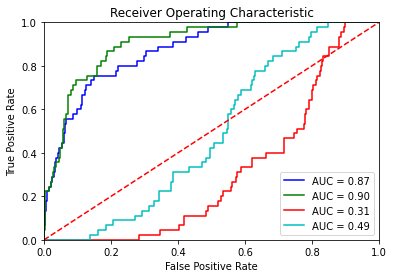

In [44]:
from sklearn.metrics import accuracy_score, roc_curve, auc
preds = probs[:, 1]
fpr0, tpr0, threshold0 = roc_curve(y_val, probs[:, 0], pos_label=1)
fpr1, tpr1, threshold1 = roc_curve(y_val, probs[:, 1], pos_label=1)
fpr2, tpr2, threshold2 = roc_curve(y_val, probs[:, 2], pos_label=1)
fpr3, tpr3, threshold3 = roc_curve(y_val, probs[:, 3], pos_label=1)
print("here")
roc_auc = auc(fpr1, tpr1)
print(f'AUC: {roc_auc:.4f}')
     
# Get accuracy over the test set
#y_pred = np.where(preds >= 0.5, 1, 0)
accuracy = accuracy_score(y_val, yval)
print(f'Accuracy: {accuracy*100:.2f}%')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr0, tpr0, 'b', label = 'AUC = %0.2f' % auc(fpr0, tpr0))
plt.plot(fpr1, tpr1, 'g', label = 'AUC = %0.2f' % auc(fpr1, tpr1))
plt.plot(fpr2, tpr2, 'r', label = 'AUC = %0.2f' % auc(fpr2, tpr2))
plt.plot(fpr3, tpr3, 'c', label = 'AUC = %0.2f' % auc(fpr3, tpr3))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**2. A Fine-tuned BERT model with the classifier**

BERT Tokenizer

In [23]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [24]:
# Concatenate train data and test data
print(X_train)
sentiment_data = np.concatenate([X_train, X_val])

# Encode our concatenated data
encoded_sentiment_data = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentiment_data]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_sentiment_data])
print('Max length: ', max_len)

['To be enchanting, offer the likeability of Virgin Airlines, the trustworthiness of Zappos &amp; great products of Apple. @mention #sxsw'
 "Temporary Apple Store will be a block from my office! Can't wait to see the line tomorrow. Photos to come... #sxsw #iPad2"
 'RT @mention Google party broke up. At the Tumblr / Funny or Die party. Fun! #sxsw'
 ...
 'Does anyone else at #sxsw know where #Google is showing off Circles today?'
 'Google looking to launch new social {link} #sxsw #in'
 "Whoa! There's a dude in front of me using Google Wave! #sxsw #xplat"]
Max length:  65


In [27]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  The Web DesignerÛªs Guide to iOS (and Android) Apps, today @mention 10 a.m! {link} #sxsw
Token IDs:  [101, 4773, 5859, 2226, 29653, 2015, 5009, 16380, 11924, 18726, 2651, 1030, 5254, 2184, 2572, 999, 1063, 4957, 1065, 1001, 1055, 2595, 26760, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


Create PyTorch DataLoader

In [29]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

Create BertClassifier

In [37]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 4

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 142 µs, sys: 0 ns, total: 142 µs
Wall time: 149 µs


Optimizer & Learning Rate Scheduler

In [31]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

Training Loop

In [32]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [38]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.992614   |     -      |     -     |  394.26  
   1    |   40    |   0.825568   |     -      |     -     |  359.94  
   1    |   60    |   0.935877   |     -      |     -     |  357.56  
   1    |   80    |   0.844118   |     -      |     -     |  358.21  
   1    |   100   |   0.893005   |     -      |     -     |  358.59  
   1    |   120   |   0.874746   |     -      |     -     |  357.35  
   1    |   140   |   0.816805   |     -      |     -     |  358.21  
   1    |   159   |   0.765380   |     -      |     -     |  325.08  
----------------------------------------------------------------------
   1    |    -    |   0.869934   |  0.782291  |   68.15   |  2977.80 
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elaps

Evaluation on Validation Set

In [39]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [40]:
def label(probs):
  rs = []
  for p in probs:
    max = -1
    index =-1
    for i in range(len(p)):
      if max < p[i]:
        max = p[i]
        index = i
    rs.append(index)
  return rs

AUC: 0.9039
Accuracy: 68.60%


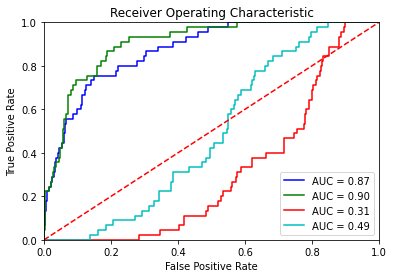

In [45]:
from sklearn.metrics import accuracy_score, roc_curve, auc
probs = bert_predict(bert_classifier, val_dataloader)
preds = probs[:, 1]
fpr0, tpr0, threshold0 = roc_curve(y_val, probs[:, 0], pos_label=1)
fpr1, tpr1, threshold1 = roc_curve(y_val, probs[:, 1], pos_label=1)
fpr2, tpr2, threshold2 = roc_curve(y_val, probs[:, 2], pos_label=1)
fpr3, tpr3, threshold3 = roc_curve(y_val, probs[:, 3], pos_label=1)
roc_auc = auc(fpr1, tpr1)
print(f'AUC: {roc_auc:.4f}')
y_pred = label(probs)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')
plt.title('Receiver Operating Characteristic')
plt.plot(fpr0, tpr0, 'b', label = 'AUC = %0.2f' % auc(fpr0, tpr0))
plt.plot(fpr1, tpr1, 'g', label = 'AUC = %0.2f' % auc(fpr1, tpr1))
plt.plot(fpr2, tpr2, 'r', label = 'AUC = %0.2f' % auc(fpr2, tpr2))
plt.plot(fpr3, tpr3, 'c', label = 'AUC = %0.2f' % auc(fpr3, tpr3))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()